<a href="https://colab.research.google.com/github/HektorLin/Etherscan_visualization/blob/master/Etherscan_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

pd.options.display.float_format = '{:,.3f}'.format

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, YearLocator
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

# Univariate Plots

In [ ]:
# load the dataset
#df = pd.read_csv("export-verified-contracts.csv",sep=",")
df = pd.read_csv("export-NetworkUtilization.csv",sep=",")

In [ ]:
#reformat column names to non-unique, as the axis labels can always be renamed later
df["Date(UTC)"] = pd.to_datetime(df["Date(UTC)"])
df.columns = ["Date","TimeStamp","Value"]
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.week

Text(0, 0.5, 'This can be renamed')

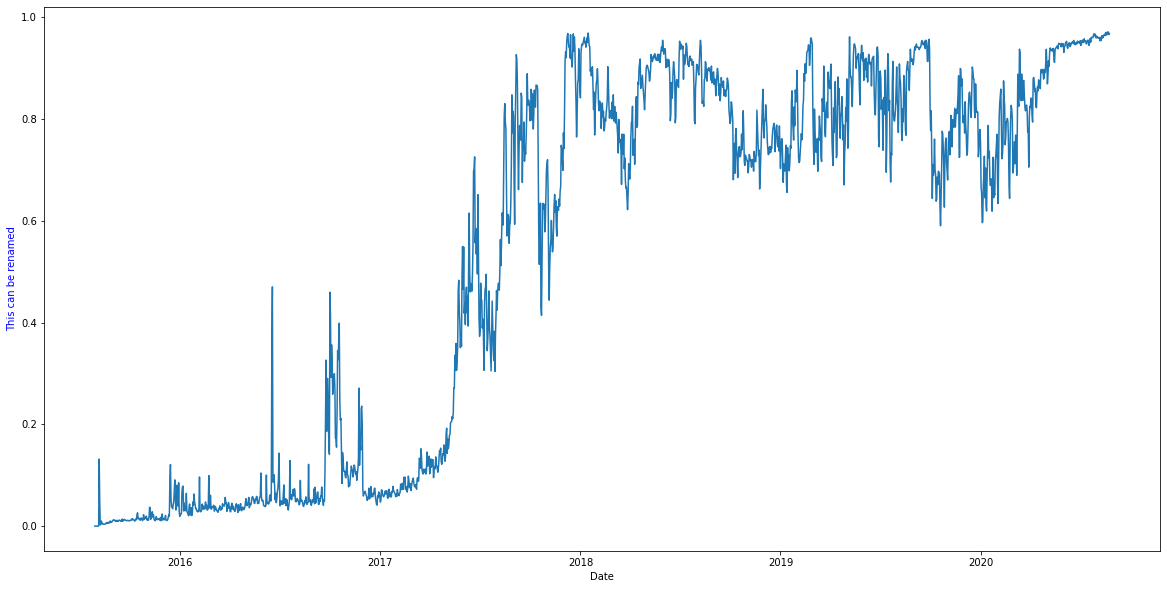

In [ ]:
# time series plot
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="Date", y="Value", data=df)
ax.set_ylabel('This can be renamed', color='b')

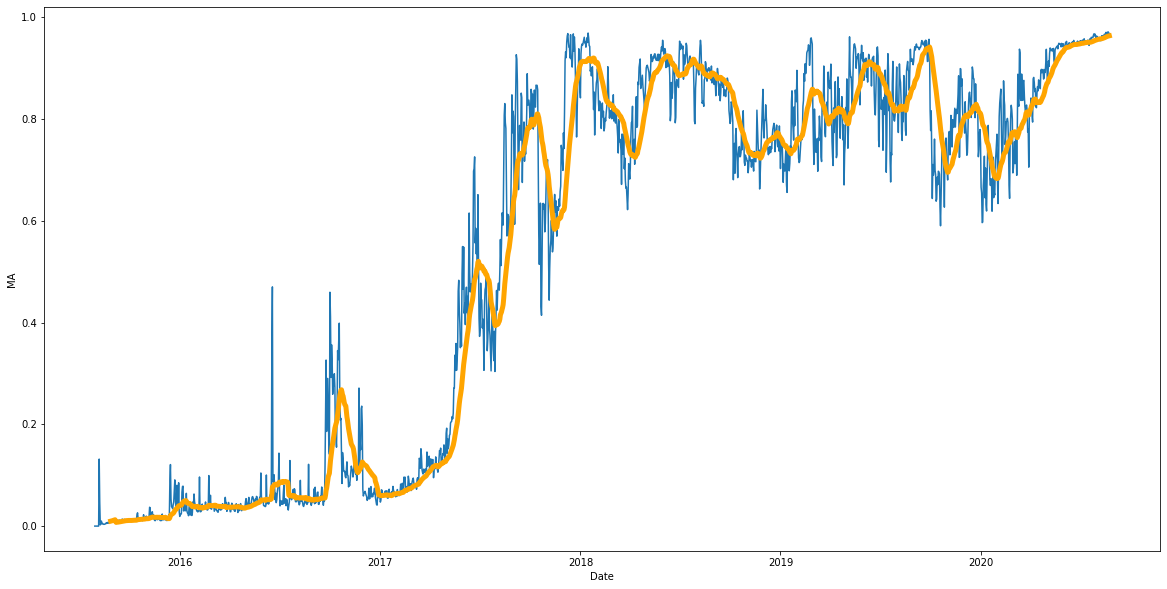

In [ ]:
# time series with moving average (30 days)
plot_df = df.copy()
plot_df["MA"] = plot_df["Value"].rolling(30).mean() 
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="Date", y="Value", data=plot_df)
ax = sns.lineplot(x="Date", y="MA", data=plot_df, linewidth=5, color="orange")

In [ ]:
# create custom colormap, using RGB values
myColors = ((0.9, 0.9, 0.9), (0.5, 0.5, 0.9), (0.0, 0.0, 1.0)) # from light blue to blue
#myColors = ((0.9, 0.9, 0.9), (200/255, 0.5, 0.5), (150/255, 0.0, 0.0)) # from light red to deep red
cus_cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors)*20)

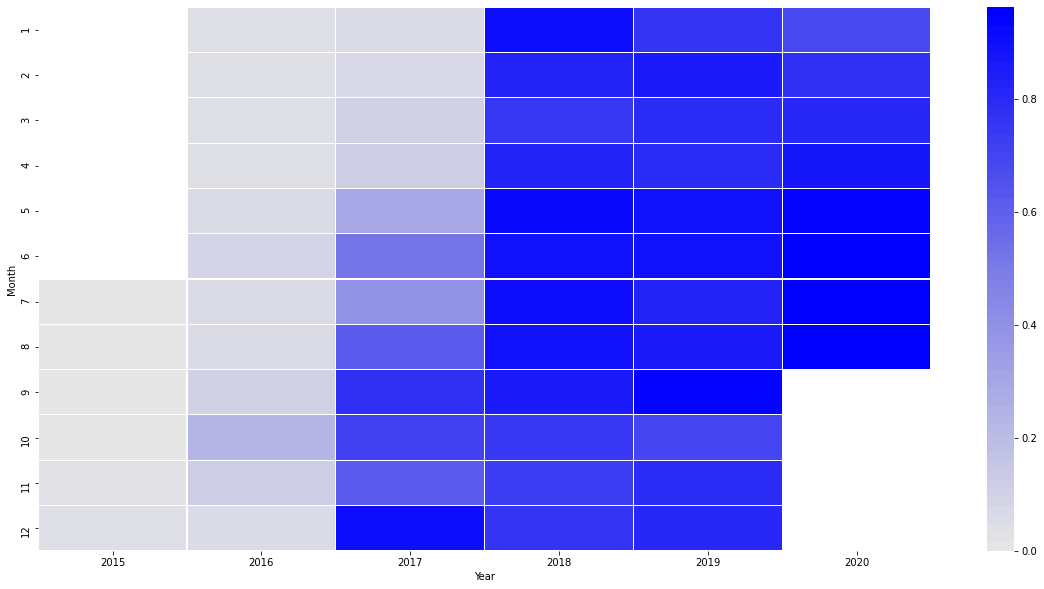

In [ ]:
# heatmap by year and month
fig, ax = plt.subplots(figsize=(20,10))
plot_df = df[["Year","Month","Value"]].copy()
plot_df = plot_df.pivot_table(index="Month", columns="Year", values="Value",aggfunc="mean")
ax = sns.heatmap(plot_df, linewidths=0.1,cmap=cus_cmap)

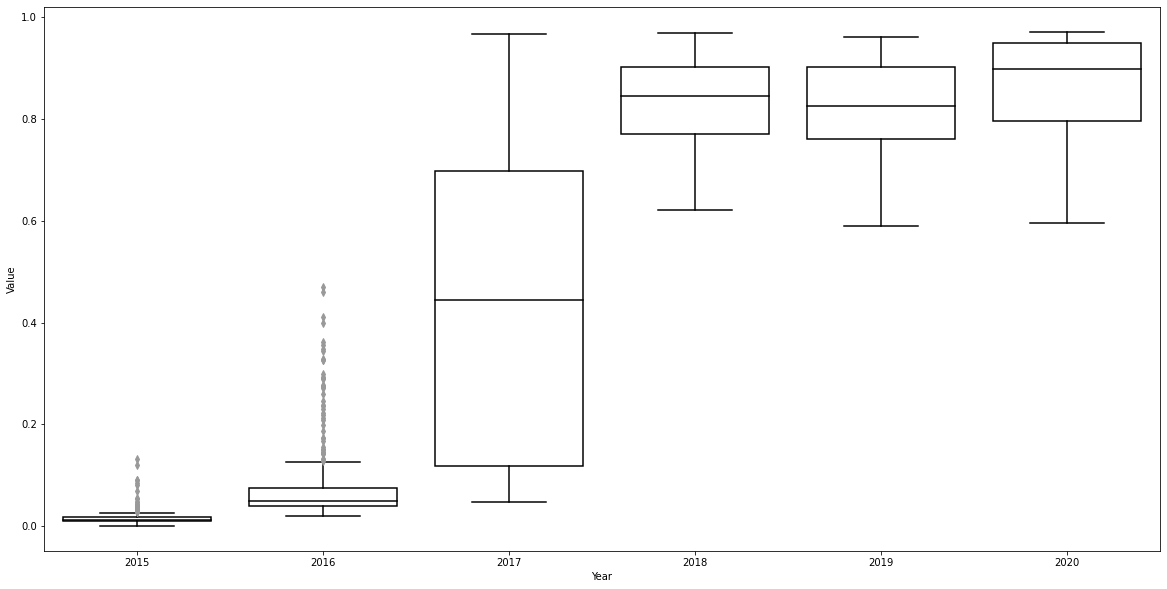

In [ ]:
# Boxplots groupped by year
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x=df["Year"],y=df["Value"], color='white')

# iterate over boxes (codes from https://stackoverflow.com/questions/43434020/black-and-white-boxplots-in-seaborn)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

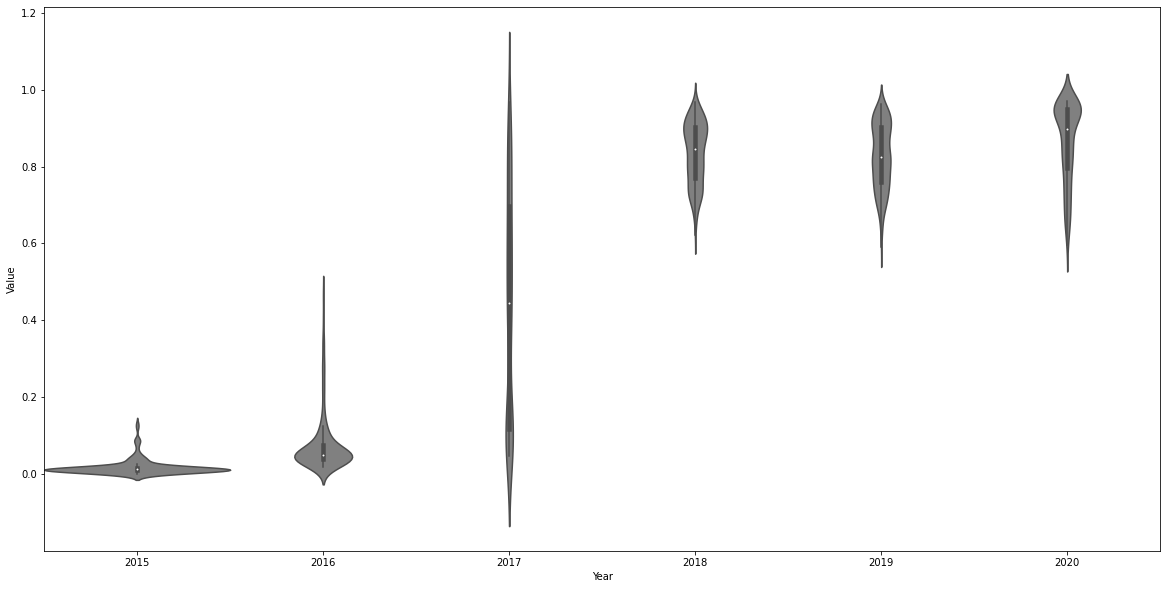

In [ ]:
# violinplot groupped by year
fig, ax = plt.subplots(figsize=(20,10))

# adjust the "width" can alter the fatness of the violine.
ax = sns.violinplot(x=df["Year"],y=df["Value"], color='grey', width=1)

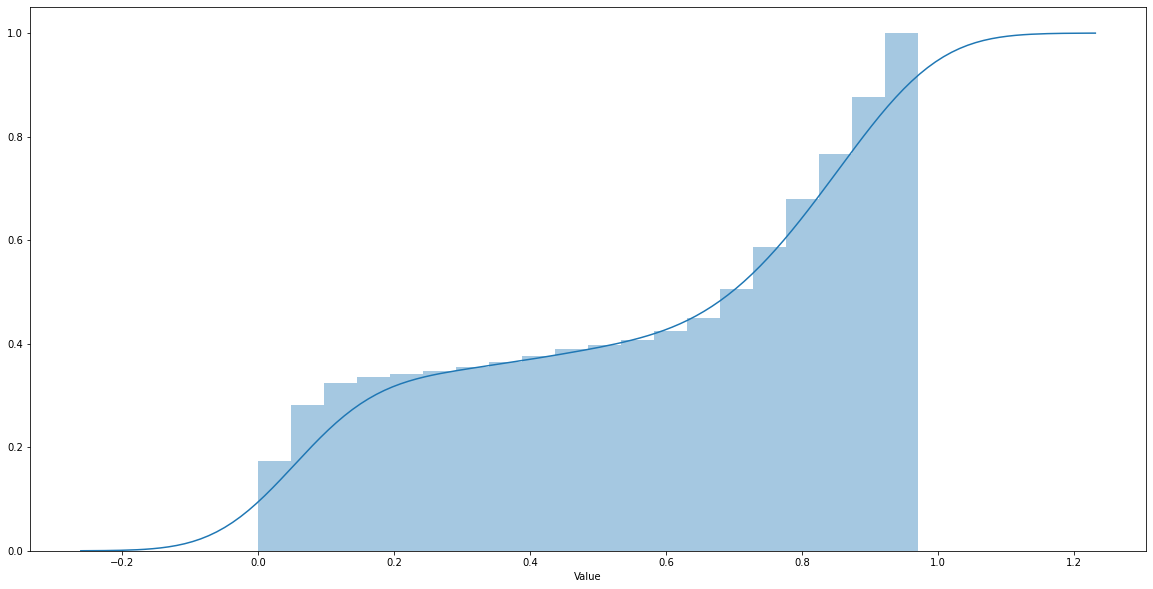

In [ ]:
# ECDF
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df["Value"], hist_kws={'cumulative': True}, kde_kws={'cumulative': True},bins=20)

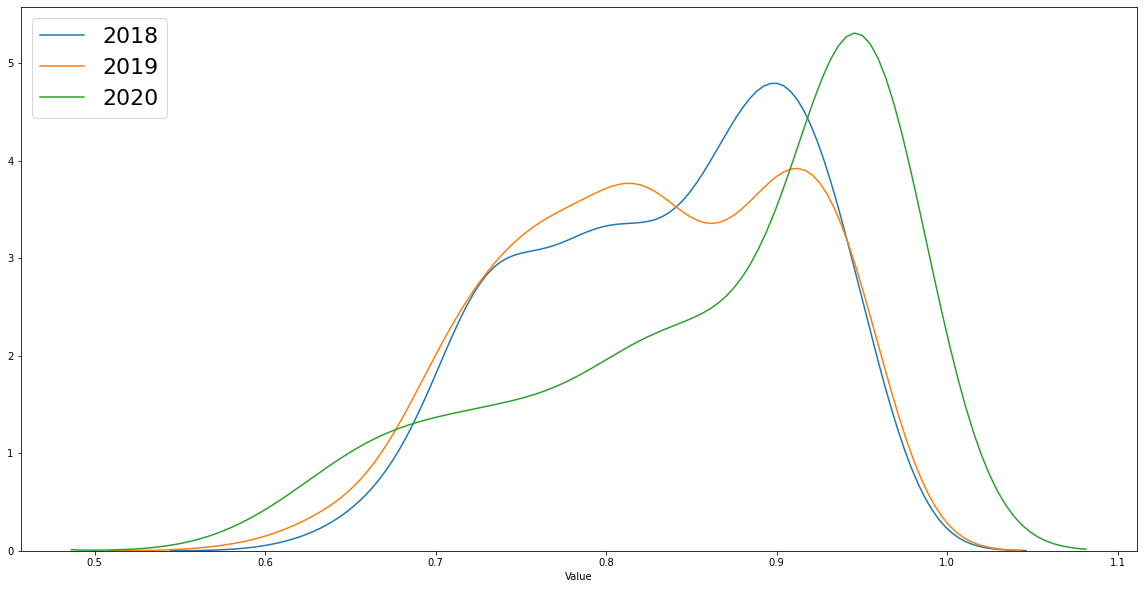

In [ ]:
# ECDF by years
fig, ax = plt.subplots(figsize=(20,10))
for year in df.loc[df["Year"]>2017,"Year"].unique():
  sns.distplot(df.loc[df["Year"]==year,"Value"], hist=False, label = year)
  #legend_list.append(str(year))
ax.legend(loc='upper left', fontsize=22)

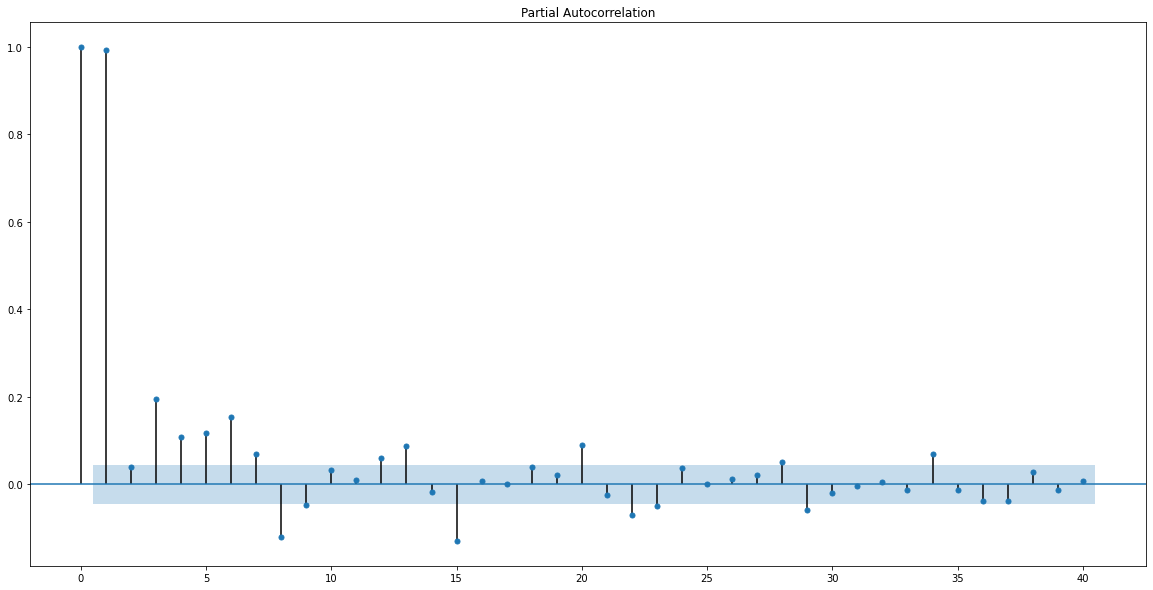

In [ ]:
# partial auto correlation at daily
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(20,10))
plot_pacf(df["Value"].values, lags=40,ax=ax)
plt.show()

# Multivariate Plots

In [3]:
# load the dataset, don't need the date as UnixTimeStamp is given
data = []
to_include = ["export-verified-contracts.csv",
              "export-NetworkUtilization.csv",
              "export-GasUsed.csv",
              "export-GasLimit.csv",
              "export-TxGrowth.csv",
              "export-tokenerc-20txns.csv",
              "export-AddressCount.csv"]
for i in to_include:
    table = pd.read_csv(i,sep=",").iloc[:,1:]
    variable_name = i.split(".")[0].replace("export-","")
    table.columns = ["UnixTimeStamp",variable_name]
    data.append(table)

In [4]:
# construct a main df by inner merge on date (i.e. observations with missing values on any date are dropped)
df = data[0]
for i in range(1,len(data)):
    df = df.merge(data[i],on=["UnixTimeStamp"],how="inner")
df["Date"] = pd.to_datetime(df["UnixTimeStamp"],unit="s")
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.week

In [5]:
df.head()

,UnixTimeStamp,verified-contracts,NetworkUtilization,GasUsed,GasLimit,TxGrowth,tokenerc-20txns,AddressCount,Date,Year,Month,Week
0,1458777600,12,0.057,1626133605,4714155,36947,4911,130970,2016-03-24,2016,3,12
1,1458864000,2,0.046,1312008358,4713540,36762,2164,132066,2016-03-25,2016,3,12
2,1458950400,5,0.046,1332524164,4722269,36646,5508,133107,2016-03-26,2016,3,12
3,1459036800,1,0.029,825632165,4713640,29974,510,134131,2016-03-27,2016,3,12
4,1459123200,1,0.042,1184635969,4713570,33613,4227,135514,2016-03-28,2016,3,13


In [ ]:
# export first 10 rows as table to latex
df.iloc[0:10,0:2].to_latex("T1.tex",index=False,float_format="%.3f")

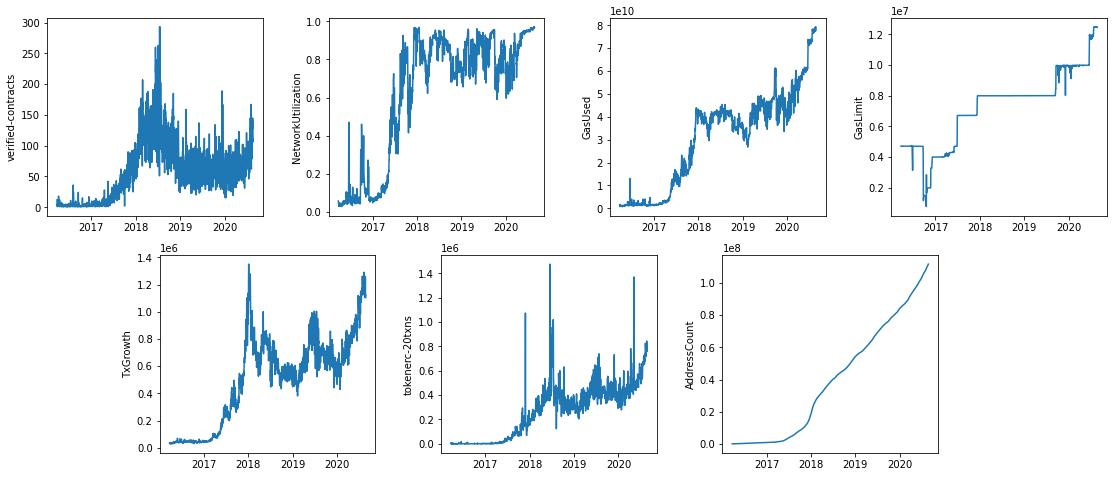

In [ ]:
# multiple time series

fig = plt.subplots(figsize=(20, 8))

# Because there are 7 times series, I have to manually draw the frames to achieve better alignment.
gs = gridspec.GridSpec(2, 20, height_ratios=[1,1]) 
ax1 = plt.subplot(gs[0,0:4])
ax2 = plt.subplot(gs[0,5:9])
ax3 = plt.subplot(gs[0,10:14])
ax4 = plt.subplot(gs[0,15:19])
ax5 = plt.subplot(gs[1,2:6])
ax6 = plt.subplot(gs[1,7:11])
ax7 = plt.subplot(gs[1,12:16])
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

# plot in every subplot a time series
xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

for i in range(0,7):
    axes[i].plot(df["Date"],df.iloc[:,i+1])
    axes[i].xaxis.set_major_locator(YearLocator())
    years_fmt = mdates.DateFormatter('%Y')
    axes[i].xaxis.set_major_formatter(years_fmt)
    axes[i].set_ylabel(df.iloc[:,i+1].name)

In [ ]:
# correlation matrix
# maybe the correlation should be run on transformed variables (i.e. de-trended or first difference)
corr = df[["verified-contracts","NetworkUtilization","GasUsed","GasLimit","TxGrowth","tokenerc-20txns","AddressCount"]].corr()
corr

,verified-contracts,NetworkUtilization,GasUsed,GasLimit,TxGrowth,tokenerc-20txns,AddressCount
verified-contracts,1.000,0.707,0.646,0.592,0.683,0.642,0.442
NetworkUtilization,0.707,1.000,0.897,0.831,0.902,0.801,0.725
GasUsed,0.646,0.897,1.000,0.942,0.937,0.902,0.906
GasLimit,0.592,0.831,0.942,1.000,0.866,0.845,0.895
TxGrowth,0.683,0.902,0.937,0.866,1.000,0.823,0.764
tokenerc-20txns,0.642,0.801,0.902,0.845,0.823,1.000,0.858
AddressCount,0.442,0.725,0.906,0.895,0.764,0.858,1.000


In [ ]:
# set the value at the diagonal to 0, from https://stackoverflow.com/questions/24475094/set-values-on-the-diagonal-of-pandas-dataframe
# corr.values[[np.arange(corr.shape[0])]*2] = 0



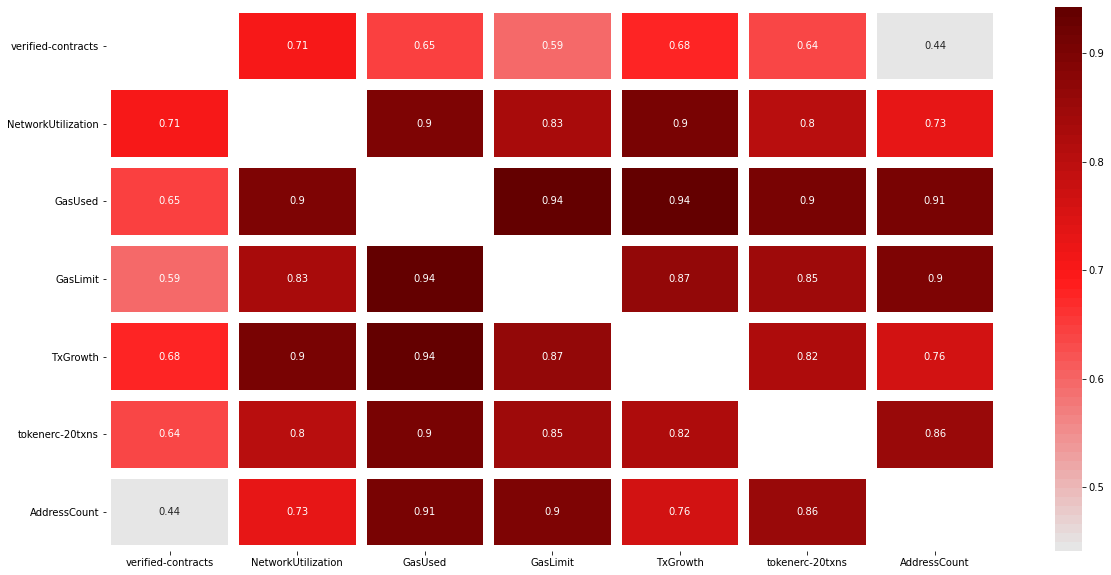

In [ ]:
# correlation heatmap
# create custom colormap
myColors = ((0.9, 0.9, 0.9), (1, 0.1, 0.1), (100/255, 0.0, 0.0)) # from light red to deep red
cus_cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors)*20)

# create a mask same dimention as the corr matrix, but with 1 on the diagonal and 0 everywhere else.
mask = np.zeros(corr.shape)
np.fill_diagonal(mask,1)

# create the heatmap with custom color map and the mask on top
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(corr, linewidths=10, cmap=cus_cmap, annot=True, mask=mask)

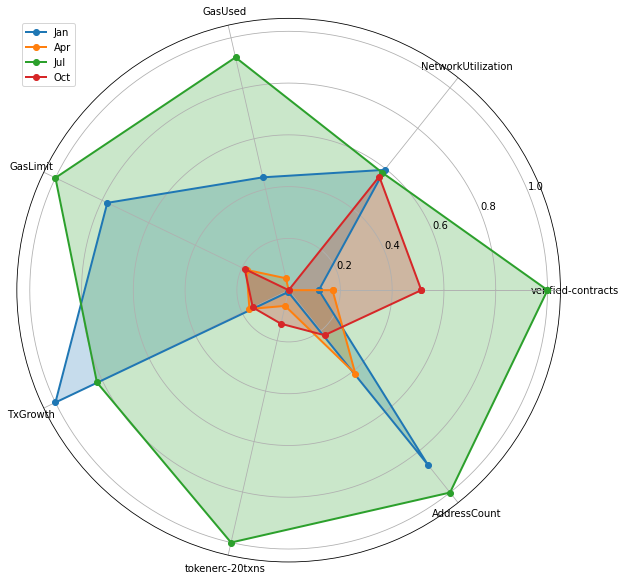

In [ ]:
# Radar plot

# I use mean data grouped by month
df_grouped = df[["verified-contracts","NetworkUtilization","GasUsed","GasLimit","TxGrowth","tokenerc-20txns","AddressCount","Month"]].groupby("Month").mean()

# scale the data with MinMax
scaler = MinMaxScaler()
plot_data = scaler.fit_transform(df_grouped)

# modified from https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way
labels=np.array(df_grouped.columns)
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, polar=True)
for i in range(0,4): #plot all 12 months will be messy, so only the first of a quarter
  stats = plot_data[i*3]
  stats=np.concatenate((stats,[stats[0]]))
  ax.plot(angles, stats, 'o-', linewidth=2)
  ax.fill(angles, stats, alpha=0.25)
  ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True) #The author had this line, but I don't see any difference
ax.legend(["Jan","Apr","Jul","Oct"],loc="upper left")

In [55]:
def f(x, y):
    return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 40)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [76]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.990,1.010,Female,No,Sun,Dinner,2
1,10.340,1.660,Male,No,Sun,Dinner,3
2,21.010,3.500,Male,No,Sun,Dinner,3
3,23.680,3.310,Male,No,Sun,Dinner,2
4,24.590,3.610,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.030,5.920,Male,No,Sat,Dinner,3
240,27.180,2.000,Female,Yes,Sat,Dinner,2
241,22.670,2.000,Male,Yes,Sat,Dinner,2
242,17.820,1.750,Male,No,Sat,Dinner,2


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'Label'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


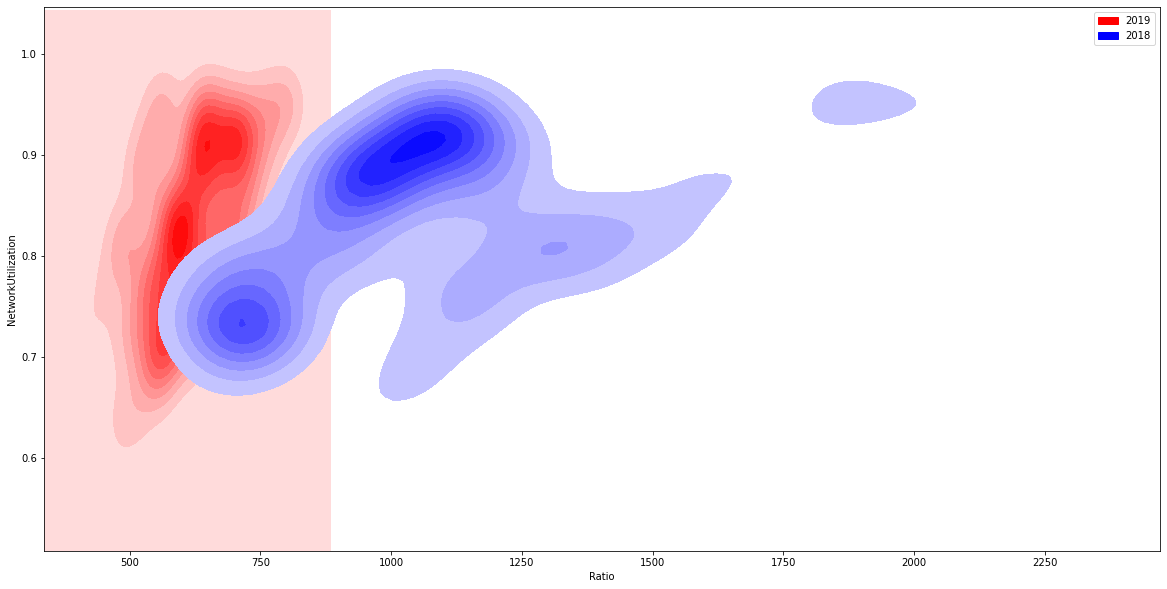

In [109]:
# density contour plot
#https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/
#https://stackoverflow.com/questions/49991657/add-labels-to-seaborn-bivariate-kde-plot

df["Ratio"] = df["GasUsed"]/df["AddressCount"] #Just a ratio, nothing meaningful
fig, ax = plt.subplots(figsize=(20,10))

#I want to show the difference between shade_lowest=True and shade_lowest=False
ax = sns.kdeplot(df.loc[df["Year"]==2019,"Ratio"],  df.loc[df["Year"]==2019,'NetworkUtilization'], color='r', shade=True, Label='2019', shade_lowest=True)
ax = sns.kdeplot(df.loc[df["Year"]==2018,"Ratio"],  df.loc[df["Year"]==2018,'NetworkUtilization'], color='b', shade=True, Label='2018', shade_lowest=False)

# it seems one have to add the color legend by oneself when ploting bivariate coutour.
# it's only two so I did it raw without a loop
label_patches = []
Y2019 = mpatches.Patch(color='r',label='2019')
label_patches.append(Y2019)
Y2018 = mpatches.Patch(color='b',label='2018')
label_patches.append(Y2018)

plt.legend(handles=label_patches, loc='upper right')

# 3D plots

In [ ]:
# I use the subset from 2018 onwards
df = df.loc[df["Year"]>=2018,:]

In [16]:
df.head()

,UnixTimeStamp,verified-contracts,NetworkUtilization,GasUsed,GasLimit,TxGrowth,tokenerc-20txns,AddressCount,Date,Year,Month,Week,Ratio
0,1458777600,12,0.057,1626133605,4714155,36947,4911,130970,2016-03-24,2016,3,12,0.000
1,1458864000,2,0.046,1312008358,4713540,36762,2164,132066,2016-03-25,2016,3,12,0.000
2,1458950400,5,0.046,1332524164,4722269,36646,5508,133107,2016-03-26,2016,3,12,0.000
3,1459036800,1,0.029,825632165,4713640,29974,510,134131,2016-03-27,2016,3,12,0.000
4,1459123200,1,0.042,1184635969,4713570,33613,4227,135514,2016-03-28,2016,3,13,0.000


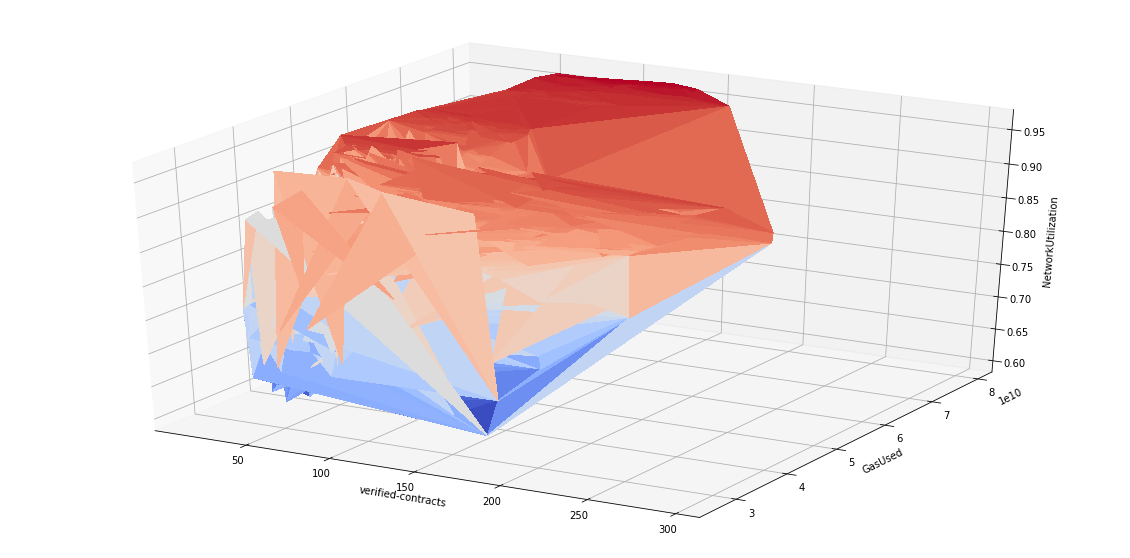

In [ ]:
# surface plots
fig = plt.figure(figsize=(20,10))
ax=fig.gca(projection='3d')
ax.plot_trisurf(df["verified-contracts"], df["GasUsed"], df["NetworkUtilization"],cmap=cm.coolwarm,linewidth=0, antialiased=False)
#ax.xaxis.set_major_locator(ticker.MaxNLocator(3,integer=True))
ax.set_xlabel("verified-contracts", color="k")
ax.set_ylabel("GasUsed", color="k")
ax.set_zlabel("NetworkUtilization", color="k")
#fig.colorbar(surf, shrink=0.5, aspect=5) #to include a color bar
plt.show()

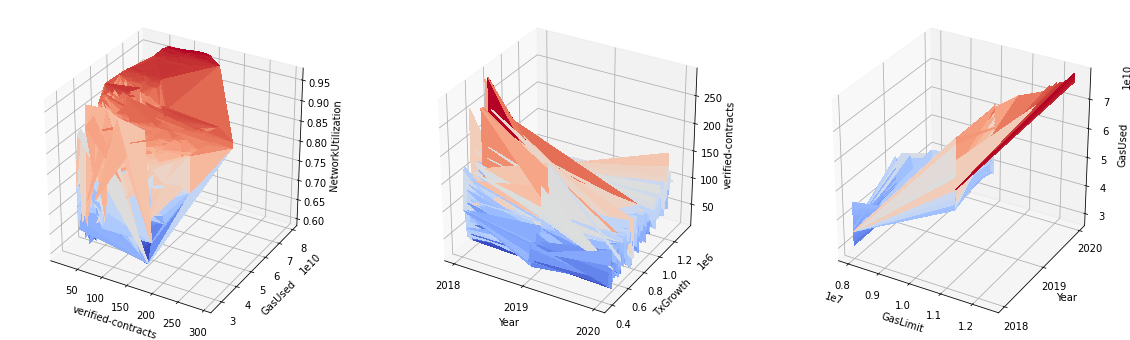

In [ ]:
# multiple surface plots
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_trisurf(df["verified-contracts"], df["GasUsed"], df["NetworkUtilization"],cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax1.set_xlabel("verified-contracts", color="k")
ax1.set_ylabel("GasUsed", color="k")
ax1.set_zlabel("NetworkUtilization", color="k")


ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_trisurf(df["Year"], df["TxGrowth"], df["verified-contracts"],cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax2.set_xlabel("Year", color="k")
ax2.xaxis.set_major_locator(ticker.MaxNLocator(3,integer=True))
ax2.set_ylabel("TxGrowth", color="k")
ax2.set_zlabel("verified-contracts", color="k")


ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_trisurf(df["GasLimit"], df["Year"], df["GasUsed"],cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax3.set_xlabel("GasLimit", color="k")
ax3.set_ylabel("Year", color="k")
ax3.yaxis.set_major_locator(ticker.MaxNLocator(3,integer=True))
ax3.set_zlabel("GasUsed", color="k")

plt.show()

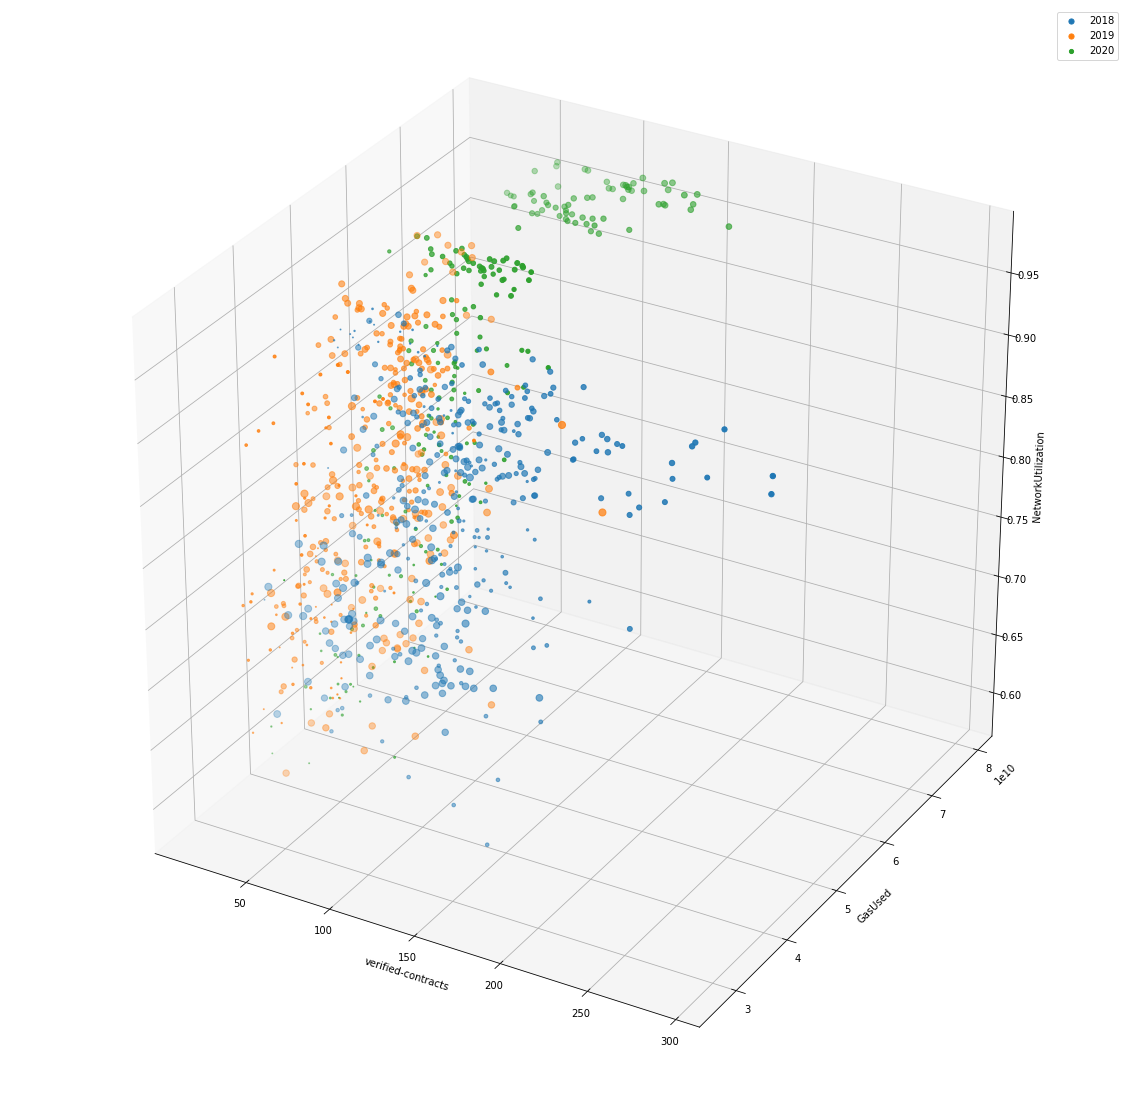

In [ ]:
# 3D scatter plots by groups and with variable sizes

fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
legend_list = []

for year in df["Year"].unique():
  plot_data = df.loc[df["Year"]==year,:]
  #"s" determines the size of the markers
  ax.scatter(xs=plot_data["verified-contracts"], ys=plot_data["GasUsed"], zs=plot_data["NetworkUtilization"], s=plot_data["Week"]) 
  legend_list.append(year) #keep the names of the markers

ax.set_xlabel("verified-contracts", color="k")
ax.set_ylabel("GasUsed", color="k")
ax.set_zlabel("NetworkUtilization", color="k")
ax.legend(legend_list)

plt.show()